In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('finished_processed.csv')
print(dataset.keys())
print(dataset.shape)
dataset.drop(['backers_count', 'usd_pledged'], axis=1, inplace=True)
target = dataset['state']
features = dataset.drop(['state'], axis=1)
features.shape

Index(['backers_count', 'category', 'country', 'creator', 'currency', 'goal',
       'staff_pick', 'state', 'usd_pledged', 'location', 'blurb_length',
       'duration'],
      dtype='object')
(164399, 12)


(164399, 9)

In [17]:
print(dataset['state'].value_counts(normalize=True))
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
print(X_train.shape)

1    0.555691
0    0.444309
Name: state, dtype: float64
(123299, 7)


In [4]:
rf = RandomForestClassifier(n_estimators = 100, oob_score = True, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [5]:
predicted = rf.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - rf.oob_score_)
importances = [(features.keys()[i], rf.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.762530413625
0.242921678197
[('category', 0.24130480194378823), ('country', 0.013575672081016456), ('creator', 0.15902330531483128), ('currency', 0.012581457093289481), ('goal', 0.1817612428848091), ('staff_pick', 0.073018820785504895), ('location', 0.14273771505637622), ('blurb_length', 0.095292880534396149), ('duration', 0.080704104305988358)]


In [6]:
%%capture --no-stdout
from collections import OrderedDict

min_est = 10
max_est = 100

max_features = [0.2, 0.33, 0.5, 0.8, "sqrt", "log2", None]

error_scores = OrderedDict((l, []) for l in max_features)

for mf in max_features:
    
    rf_test = RandomForestClassifier(n_estimators = min_est, max_features = mf, oob_score = True, random_state = 1,
                                     warm_start = True, n_jobs = -1)
    for i in range(min_est, max_est + 1, 5):
        rf_test.set_params(n_estimators = i)
        rf_test.fit(X_train, y_train)
        oob_error = 1 - rf_test.oob_score_
        error_scores[mf].append((i, oob_error))
        print(str(mf) + ": " + str(i) + ", " + str(oob_error))

0.2: 10, 0.337764296547
0.2: 15, 0.319296993487
0.2: 20, 0.307293652017
0.2: 25, 0.297317902011
0.2: 30, 0.291867736154
0.2: 35, 0.287909877615
0.2: 40, 0.285630864808
0.2: 45, 0.283092320295
0.2: 50, 0.280910631879
0.2: 55, 0.276571586144
0.2: 60, 0.274998175168
0.2: 65, 0.274357456265
0.2: 70, 0.27303546663
0.2: 75, 0.271137641019
0.2: 80, 0.270683460531
0.2: 85, 0.271072758092
0.2: 90, 0.269377691628
0.2: 95, 0.269037056262
0.2: 100, 0.268834297115
0.33: 10, 0.322159952635
0.33: 15, 0.302054355672
0.33: 20, 0.290610629445
0.33: 25, 0.284016902002
0.33: 30, 0.277260967242
0.33: 35, 0.273562640411
0.33: 40, 0.269831872116
0.33: 45, 0.267236555041
0.33: 50, 0.26627953187
0.33: 55, 0.265395501991
0.33: 60, 0.263684214795
0.33: 65, 0.26226490077
0.33: 70, 0.261413312355
0.33: 75, 0.260586055037
0.33: 80, 0.259588480036
0.33: 85, 0.259118078817
0.33: 90, 0.258542242841
0.33: 95, 0.256287561132
0.33: 100, 0.255387310522
0.5: 10, 0.292986966642
0.5: 15, 0.277358291633
0.5: 20, 0.26541983308

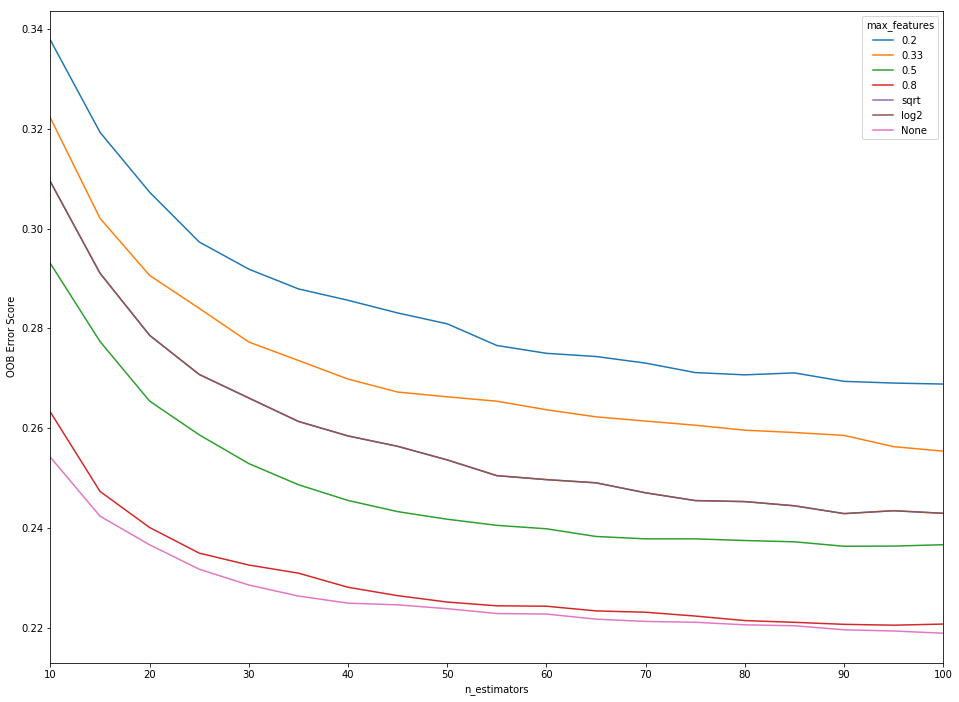

In [7]:
plt.figure(figsize=(16,12))
for mf, rf_err in error_scores.items():
    xs, ys = zip(*rf_err)
    plt.plot(xs, ys, label=str(mf))
plt.xlim(min_est, max_est)
plt.xlabel("n_estimators")
plt.ylabel("OOB Error Score")
plt.legend(title="max_features", loc="upper right")
plt.show();

In [8]:
rf_optimized = RandomForestClassifier(n_estimators = 100, max_features = None, oob_score = True, random_state = 1,
                                      min_samples_leaf=20, n_jobs = -1)
rf_optimized.fit(X_train, y_train)
predicted = rf_optimized.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - rf_optimized.oob_score_)
importances = [(features.keys()[i], rf_optimized.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.79201946472
0.210650532446
[('category', 0.47294272498758039), ('country', 0.009816539234621429), ('creator', 0.043992530268674557), ('currency', 0.01604596276592558), ('goal', 0.2118678980509861), ('staff_pick', 0.12705213360178919), ('location', 0.047728165847481928), ('blurb_length', 0.027254599745785767), ('duration', 0.043299445497155226)]


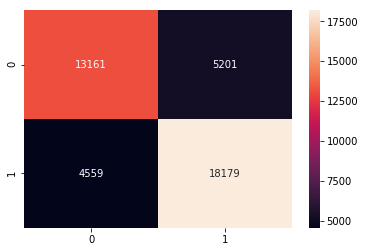

In [6]:
from sklearn.metrics import confusion_matrix

cfmtx = confusion_matrix(y_test, predicted)
sns.heatmap(cfmtx, annot=True, fmt='g')

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

rf = RandomForestClassifier(n_estimators=100)
# We want to have bootstrap=True for oob_error
param_dist = {"n_estimators": [10, 30, 50, 100],
              "max_depth": [3, None],
              "max_features": [0.8, "sqrt", None],
              "min_samples_split": sp_randint(2, 15),
              "min_samples_leaf": sp_randint(1, 15),
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              "oob_score": [True],
              "n_jobs": [-1],
              "random_state": [1]}
rsearch = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, n_jobs=-1, random_state=1)
rsearch.fit(X_train, y_train)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [10, 30, 50, 100], 'max_depth': [3, None], 'max_features': [0.8, 'sqrt', None], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020300C70CC0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020300C70E10>, 'bootstrap': [True], 'criterion': ['gini', 'entropy'], 'oob_score': [True], 'n_jobs': [-1], 'random_state': [1]},
          pre_d

In [8]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(rsearch.cv_results_)
print(rsearch.best_score_)
print(rsearch.best_estimator_)

Model with rank: 1
Mean validation score: 0.7868 (std: 0.0010)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 13, 'min_samples_split': 14, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 1}

Model with rank: 2
Mean validation score: 0.7867 (std: 0.0007)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 9, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': True, 'random_state': 1}

Model with rank: 3
Mean validation score: 0.7861 (std: 0.0002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': True, 'random_state': 1}

0.786778481577
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=N

In [9]:
best = rsearch.best_estimator_
best.fit(X_train, y_train)
predicted = best.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - best.oob_score_)
importances = [(features.keys()[i], best.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.793090024331
0.209985482445
[('category', 0.45814502433421384), ('country', 0.0095227359709740989), ('creator', 0.069703325143855119), ('currency', 0.013754640963044788), ('goal', 0.1856175094359824), ('staff_pick', 0.10215003733928889), ('location', 0.069493105060796687), ('blurb_length', 0.041619679216535685), ('duration', 0.049993942535308679)]


In [10]:
features.drop(['country', 'currency'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
best.fit(X_train, y_train)
predicted = best.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - best.oob_score_)
importances = [(features.keys()[i], best.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.794647201946
0.207893008054
[('category', 0.47808356053245205), ('creator', 0.070891421366851601), ('goal', 0.18670266525553264), ('staff_pick', 0.10080647361138334), ('location', 0.071546549717216468), ('blurb_length', 0.041706393146034443), ('duration', 0.050262936370529449)]


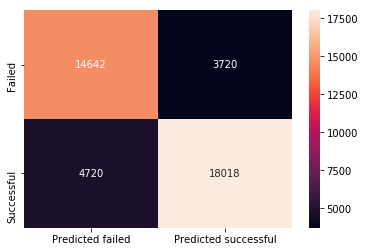

In [15]:
cfmtx = confusion_matrix(y_test, predicted)
sns.heatmap(cfmtx, annot=True, fmt='g', yticklabels=['Failed', 'Successful'], 
            xticklabels=['Predicted failed', 'Predicted successful'])

In [11]:
best.fit(features, target)
from sklearn.externals import joblib

joblib.dump(best, 'model.pkl') 


['model.pkl']